In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import YearEnd

In [2]:
def load_deepsearch_data(filepath, col_name):
    df=pd.read_excel(filepath)
    if len(df.columns)>2:
        del df[df.columns[-1]]
    df.columns=['date', col_name]
    
    df['date'] = df['date'].astype('str').str[:15]
    df['date'] = pd.to_datetime(df['date'])
    
    df=df.set_index('date')
    df=df.sort_index(ascending=True)
    return df

In [3]:
def load_world_bank_data(filepath, country, column):
    df = pd.read_excel(filepath, sheet_name = 'Data', skiprows = 3)
    df = df.set_index('Country Code')
    df = df.loc[country].to_frame()
    df = df.iloc[3:] 
    df = df.dropna() 
    df = df.astype(float)
    
    df['date'] =  pd.to_datetime(df.index) + YearEnd(0)
    df = df.set_index('date')
    df.columns = [column]
    
    return df

In [4]:
filenames = [
    'krw_cad_xr',
    'current_account_korea', 'current_account_can', 'current_account_us','current_account_china',
    'gdp_korea', 'gdp_can', 'gdp_china', 'gdp_us', 
    'gdp_growth_korea', 'gdp_growth_can', 'gdp_growth_us','gdp_growth_china', 
    'cpi_korea', 'cpi_can','cpi_china', 'cpi_us',
    'int_rate_korea', 'int_rate_can', 'int_rate_us','int_rate_china',
    'foreign_reserves_korea', 'foreign_reserves_can', 'foreign_reserves_china', 
    'hdebt_to_gdp_canada', 'hdebt_to_gdp_korea',
    'oil_price'
]

In [5]:
dfs=[]
for fname in filenames:
    print(f'Loading {fname}...')
    filepath = f'data/{fname}.xlsx'
    df=load_deepsearch_data(filepath, fname)
    
    if fname in ['gdp_growth_korea', 'gdp_growth_can','gdp_growth_us','gdp_growth_china', \
                 'current_account_can', 'current_account_us','current_account_china']:#quarterly
        df=df.fillna(0)
        df[fname]=df.rolling(4).sum()
    elif fname in ['current_account_korea']:#monthly
        df=df.rolling(12).sum()
    dfs.append(df)
print('Data loading is completed!!')

Loading krw_cad_xr...
Loading current_account_korea...
Loading current_account_can...
Loading current_account_us...
Loading current_account_china...
Loading gdp_korea...
Loading gdp_can...
Loading gdp_china...
Loading gdp_us...
Loading gdp_growth_korea...
Loading gdp_growth_can...
Loading gdp_growth_us...
Loading gdp_growth_china...
Loading cpi_korea...
Loading cpi_can...
Loading cpi_china...
Loading cpi_us...
Loading int_rate_korea...
Loading int_rate_can...
Loading int_rate_us...
Loading int_rate_china...
Loading foreign_reserves_korea...
Loading foreign_reserves_can...
Loading foreign_reserves_china...
Loading hdebt_to_gdp_canada...
Loading hdebt_to_gdp_korea...
Loading oil_price...
Data loading is completed!!


In [6]:
df_ppp_xr = load_world_bank_data('data/world_ppp_xr.xls', 'KOR','krw_usd_ppp_xr')
dfs.append(df_ppp_xr)
df_ppp_xr = load_world_bank_data('data/world_ppp_xr.xls', 'CAN','can_usd_ppp_xr')
dfs.append(df_ppp_xr)
df_ppp_xr = load_world_bank_data('data/world_ppp_xr.xls', 'CHN','chn_usd_ppp_xr')
dfs.append(df_ppp_xr)

In [7]:
dfs

[            krw_cad_xr
 date                  
 1964-12-14      236.81
 1964-12-15      236.81
 1964-12-16      236.81
 1964-12-17      236.81
 1964-12-18      236.81
 ...                ...
 2022-08-08     1003.98
 2022-08-09     1014.70
 2022-08-10     1012.73
 2022-08-11     1024.78
 2022-08-12     1020.25
 
 [16257 rows x 1 columns],
             current_account_korea
 date                             
 1980-01-31                    NaN
 1980-02-29                    NaN
 1980-03-31                    NaN
 1980-04-30                    NaN
 1980-05-31                    NaN
 ...                           ...
 2022-02-28                81798.7
 2022-03-31                81028.7
 2022-04-30                80768.2
 2022-05-31                74221.8
 2022-06-30                71001.1
 
 [510 rows x 1 columns],
             current_account_can
 date                           
 1950-03-31                  NaN
 1950-06-30                  NaN
 1950-09-30                  NaN
 1950-12-31 

In [8]:
df_merged = pd.concat(dfs, axis=1)
df_merged = df_merged.resample('M').last()
df_merged = df_merged.fillna(method = 'ffill')

In [9]:
df_merged['ann_ret'] = df_merged['krw_cad_xr'].pct_change(periods=12)*100
df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)

In [10]:
df_merged['krw_can_ppp_xr'] = df_merged['krw_usd_ppp_xr'] / df_merged['can_usd_ppp_xr']
df_merged['real_xr_kor_can'] = df_merged['krw_can_ppp_xr'] / df_merged['krw_cad_xr']

In [11]:
df_merged['ca_gdp_korea'] = df_merged['current_account_korea'] / df_merged['gdp_korea'] * 100

In [12]:
df_merged['ca_gdp_can'] = df_merged['current_account_can'] / df_merged['gdp_can'] * 100
df_merged['ca_gdp_us'] = df_merged['current_account_us'] / df_merged['gdp_us'] * 100
df_merged['ca_gdp_china'] = df_merged['current_account_china'] / df_merged['gdp_china'] * 100

In [13]:
df_merged['reserves_to_gdp_kor'] = df_merged['foreign_reserves_korea'] / df_merged['gdp_korea']
df_merged['reserves_to_gdp_can'] = df_merged['foreign_reserves_can'] / df_merged['gdp_can'] 
df_merged['reserves_to_gdp_china'] = df_merged['foreign_reserves_china'] / df_merged['gdp_china']

In [14]:
df_merged['reserves_growth_kor'] = df_merged['foreign_reserves_korea'].pct_change(periods=12)*100
df_merged['reserves_growth_can'] = df_merged['foreign_reserves_can'].pct_change(periods=12)*100
df_merged['reserves_growth_china'] = df_merged['foreign_reserves_china'].pct_change(periods = 12) * 100

In [15]:
df_merged['infl_korea'] = df_merged['cpi_korea'].pct_change(periods=12)*100
df_merged['infl_can'] = df_merged['cpi_can'].pct_change(periods=12)*100
df_merged['infl_us'] = df_merged['cpi_us'].pct_change(periods = 12) * 100
df_merged['infl_china'] = df_merged['cpi_china'].pct_change(periods = 12) * 100

In [16]:
df_merged['infl_diff_kor_can'] = df_merged['infl_korea']-df_merged['infl_can']
df_merged['infl_diff_kor_us'] = df_merged['infl_korea']-df_merged['infl_us']
df_merged['infl_diff_us_can'] = df_merged['infl_us']-df_merged['infl_can']
df_merged['infl_diff_kor_china'] = df_merged['infl_korea'] - df_merged['infl_china']

In [17]:
df_merged['int_rate_diff_kor_can'] = df_merged['int_rate_korea']-df_merged['int_rate_can']
df_merged['int_rate_diff_kor_us'] = df_merged['int_rate_korea'] - df_merged['int_rate_us']
df_merged['int_rate_diff_can_us'] = df_merged['int_rate_can'] - df_merged['int_rate_us']

In [18]:
df_merged['oil_price_ret'] = df_merged['oil_price'].pct_change(periods = 12) * 100 

In [19]:
df_sample = df_merged[[
    'F12.ann_ret', 'real_xr_kor_can',
    'ca_gdp_korea', 'ca_gdp_can','ca_gdp_us', 'ca_gdp_china',
    'gdp_growth_korea', 'gdp_growth_can','gdp_growth_us','gdp_growth_china',
    'infl_diff_kor_can', 'infl_diff_kor_us',  'infl_diff_us_can','infl_diff_kor_china',
    'int_rate_diff_kor_can','int_rate_diff_kor_us','int_rate_diff_can_us',
    'reserves_to_gdp_kor', 'reserves_to_gdp_can', 'reserves_to_gdp_china',
    'reserves_growth_kor','reserves_growth_can','reserves_growth_china',
    'oil_price_ret'
]]

In [20]:
df_sample.head()

,F12.ann_ret,real_xr_kor_can,ca_gdp_korea,ca_gdp_can,ca_gdp_us,ca_gdp_china,gdp_growth_korea,gdp_growth_can,gdp_growth_us,gdp_growth_china,...,int_rate_diff_kor_can,int_rate_diff_kor_us,int_rate_diff_can_us,reserves_to_gdp_kor,reserves_to_gdp_can,reserves_to_gdp_china,reserves_growth_kor,reserves_growth_can,reserves_growth_china,oil_price_ret
date,,,,,,,,,,,,,,,,,,,,,
1920-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df_sample = df_sample.dropna()

In [22]:
df_sample.head()

,F12.ann_ret,real_xr_kor_can,ca_gdp_korea,ca_gdp_can,ca_gdp_us,ca_gdp_china,gdp_growth_korea,gdp_growth_can,gdp_growth_us,gdp_growth_china,...,int_rate_diff_kor_can,int_rate_diff_kor_us,int_rate_diff_can_us,reserves_to_gdp_kor,reserves_to_gdp_can,reserves_to_gdp_china,reserves_growth_kor,reserves_growth_can,reserves_growth_china,oil_price_ret
date,,,,,,,,,,,,,,,,,,,,,
2016-06-30,-2.512781,0.763573,7.426188,-3.417628,-2.279542,2.303990,3.6,0.5,1.3,6.7,...,0.801,0.851,0.05,0.252306,0.053659,0.289756,-1.296601,9.327836,-13.229492,-18.488800
2016-07-31,5.190146,0.802963,7.389667,-3.417628,-2.279542,2.303990,3.6,0.5,1.3,6.7,...,0.753,0.763,0.01,0.253325,0.053263,0.289385,0.151555,7.694106,-12.331273,-12.278978
2016-08-31,4.102294,0.804147,7.204863,-3.417628,-2.279542,2.303990,3.6,0.5,1.3,6.7,...,0.809,0.729,-0.08,0.256104,0.053810,0.287949,2.044094,7.582238,-10.463147,4.315372
2016-09-30,10.565128,0.823846,6.994582,-3.434283,-2.228268,2.351397,2.6,1.1,1.6,6.7,...,0.775,0.735,-0.04,0.257681,0.054092,0.286251,2.623100,7.342292,-9.895450,-0.659631
2016-10-31,2.680767,0.804655,6.852417,-3.434283,-2.228268,2.351397,2.6,1.1,1.6,6.7,...,0.919,0.779,-0.14,0.255905,0.053571,0.282117,1.505948,5.344080,-11.483511,7.702293


In [23]:
df_sample.tail()

,F12.ann_ret,real_xr_kor_can,ca_gdp_korea,ca_gdp_can,ca_gdp_us,ca_gdp_china,gdp_growth_korea,gdp_growth_can,gdp_growth_us,gdp_growth_china,...,int_rate_diff_kor_can,int_rate_diff_kor_us,int_rate_diff_can_us,reserves_to_gdp_kor,reserves_to_gdp_can,reserves_to_gdp_china,reserves_growth_kor,reserves_growth_can,reserves_growth_china,oil_price_ret
date,,,,,,,,,,,,,,,,,,,,,
2021-04-30,9.904075,0.734072,5.478157,-0.926039,-3.247091,2.526340,1.8,1.3,1.2,18.0,...,0.092,0.592,0.50,0.276153,0.051195,0.217226,11.962909,-3.532901,3.452124,272.930514
2021-05-31,6.498453,0.716225,5.994930,-0.926039,-3.247091,2.526340,1.8,1.3,1.2,18.0,...,0.083,0.583,0.50,0.278686,0.054214,0.218831,12.066455,2.097926,3.872435,128.186275
2021-06-30,10.071879,0.726419,6.104289,-0.572349,-3.460500,2.216771,5.8,11.5,11.7,7.6,...,0.405,0.885,0.48,0.277250,0.054122,0.218302,10.554249,2.034900,3.267072,86.322109
2021-07-31,10.404016,0.717763,6.133675,-0.572349,-3.460500,2.216771,5.8,11.5,11.7,7.6,...,0.386,0.866,0.48,0.280043,0.054818,0.219788,10.120617,-0.222345,2.583668,78.064358
2021-08-31,10.436985,0.716527,6.185632,-0.572349,-3.460500,2.216771,5.8,11.5,11.7,7.6,...,0.514,0.994,0.48,0.283250,0.064749,0.219531,10.737055,18.514934,2.133186,59.966934


In [24]:
import seaborn as sns

<AxesSubplot:>

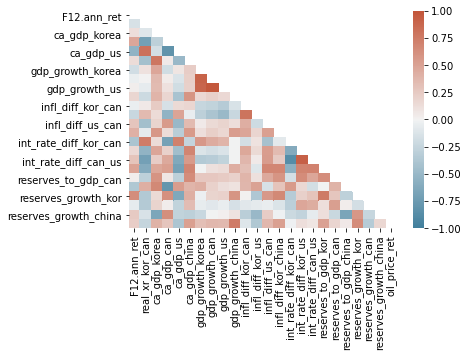

In [25]:
corr = df_sample.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True) # two color
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, cmap=cmap, mask=mask, vmin=-1, vmax=1)

In [26]:
import statsmodels.api as sm

In [27]:
y = df_sample['F12.ann_ret']
x = df_sample.iloc[:, 1:]
x=sm.add_constant(x)

In [28]:
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     16.91
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           5.06e-14
Time:                        20:54:11   Log-Likelihood:                -117.29
No. Observations:                  63   AIC:                             278.6
Df Residuals:                      41   BIC:                             325.7
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -104.8493     30.189     -3.473      0.001    -165.818     -43.881
real_xr_kor_can         101.1618     16.200      6.245      0.000      68.445     133.878
ca_gdp_korea              2.1948      1.312      1.673      0.102      -0.455       4.845
ca_gdp_can                0.9525      2.332      0.408      0.685      -3.757       5.662
ca_gdp_us                -5.2496      3.807     -1.379      0.175     -12.939       2.439
ca_gdp_china             -2.3767      2.055     -1.157      0.254      -6.526       1.773
gdp_growth_korea          1.2087      0.727      1.663      0.104      -0.259       2.677
gdp_growth_can           -0.6739      0.663     -1.016      0.316      -2.013       0.665
gdp_growth_us             0.2288      0.848      0.270      0.789      -1.483       1.941
gdp_growth_china         -0.3959      0.230     -1.720      0.093      -0.861       0.069
infl_diff_kor_can        -0.6119      0.639     -0.958      0.344      -1.902       0.678
infl_diff_kor_us          0.3211      0.660      0.487      0.629      -1.011       1.653
infl_diff_us_can         -0.9330      0.677     -1.379      0.175      -2.300       0.434
infl_diff_kor_china       0.0762      0.538      0.142      0.888      -1.009       1.162
int_rate_diff_kor_can    -4.9464      2.053     -2.409      0.021      -9.093      -0.800
int_rate_diff_kor_us     -3.8715      1.833     -2.112      0.041      -7.573      -0.170
int_rate_diff_can_us      1.0749      1.086      0.990      0.328      -1.119       3.268
reserves_to_gdp_kor     168.3293    112.148      1.501      0.141     -58.158     394.817
reserves_to_gdp_can    -530.1798    311.875     -1.700      0.097   -1160.024      99.665
reserves_to_gdp_china   -21.3326     54.352     -0.392      0.697    -131.098      88.433
reserves_growth_kor       1.1599      0.398      2.917      0.006       0.357       1.963
reserves_growth_can       0.2188      0.168      1.301      0.200      -0.121       0.558
reserves_growth_china    -0.2737      0.277     -0.986      0.330      -0.834       0.287
oil_price_ret            -0.0068      0.012     -0.563      0.577      -0.031       0.018
==============================================================================
Omnibus:                        2.375   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.305   Jarque-Bera (JB):                1.597
Skew:                           0.344   Prob(JB):                        0.450
Kurtosis:                       3.369   Cond. No.                     7.48e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.09e-31. This might indicate that there are
str

In [29]:
features = [
    'F12.ann_ret',
    'real_xr_kor_can',
    'ca_gdp_korea', #'ca_gdp_canada', 'ca_gdp_china',
    'gdp_growth_can','gdp_growth_us',
    'infl_diff_kor_can', 'infl_diff_kor_us', 'infl_diff_kor_china', 
    'int_rate_diff_kor_can','int_rate_diff_kor_us',
    'reserves_growth_china'
]

In [30]:
df_sample2 = df_merged[features]
df_sample2 = df_sample2.dropna()
y2 = df_sample2['F12.ann_ret']
x2 = df_sample2.iloc[:, 1:]
x2=sm.add_constant(x2)

In [31]:
results = sm.OLS(y2,x2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     17.36
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           2.71e-13
Time:                        20:54:11   Log-Likelihood:                -142.51
No. Observations:                  63   AIC:                             307.0
Df Residuals:                      52   BIC:                             330.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -80.9310     15.038     -5.382      0.000    -111.107     -50.755
real_xr_kor_can          92.8858     17.172      5.409      0.000      58.429     127.343
ca_gdp_korea              4.7186      1.107      4.262      0.000       2.497       6.940
gdp_growth_can           -2.9358      0.623     -4.716      0.000      -4.185      -1.687
gdp_growth_us             3.7997      0.764      4.973      0.000       2.266       5.333
infl_diff_kor_can        -0.5202      1.115     -0.466      0.643      -2.758       1.718
infl_diff_kor_us          1.9195      1.348      1.424      0.160      -0.785       4.624
infl_diff_kor_china       0.3906      0.529      0.738      0.464      -0.671       1.452
int_rate_diff_kor_can   -16.3505      2.127     -7.688      0.000     -20.618     -12.083
int_rate_diff_kor_us     -7.2940      1.471     -4.958      0.000     -10.246      -4.342
reserves_growth_china     0.6564      0.195      3.374      0.001       0.266       1.047
==============================================================================
Omnibus:                        0.965   Durbin-Watson:                   1.286
Prob(Omnibus):                  0.617   Jarque-Bera (JB):                0.757
Skew:                           0.267   Prob(JB):                        0.685
Kurtosis:                       2.950   Cond. No.                         479.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""